In [5]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

data_price = pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\(OIL) Oil Trading & Weather Dispersion\Spread trading startegy\Data.csv")

# Calculate the spread
data_price['Spread'] = data_price['Dubai Price'] - data_price['WTI']

# Calculate the mean and standard deviation of the spread
spread_mean = data_price['Spread'].mean()
spread_std = data_price['Spread'].std()

# Define thresholds
upper_threshold_spread = spread_mean + spread_std
lower_threshold_spread = spread_mean - spread_std

# Generate signals based on spread
data_price['Spread_Signal'] = 0
data_price.loc[data_price['Spread'] > upper_threshold_spread, 'Spread_Signal'] = -1  # Short Dubai / Long Texas
data_price.loc[data_price['Spread'] < lower_threshold_spread, 'Spread_Signal'] = 1   # Long Dubai / Short Texas

data_price

,DATE,Dubai,Texas,UK,Dubai Price,WTI,Brent,Spread,Spread_Signal
0,2020-07-07,36.1,28.4,12.5,43.09,40.59,43.28,2.50,0
1,2020-07-08,35.9,29.0,19.0,43.29,40.91,43.67,2.38,0
2,2020-07-09,34.9,27.2,14.8,42.79,39.64,42.35,3.15,0
3,2020-07-10,33.4,22.9,11.2,43.40,40.56,43.27,2.84,0
4,2020-07-13,39.8,29.9,16.8,43.10,40.06,42.85,3.04,0
...,...,...,...,...,...,...,...,...,...
972,2024-08-27,35.9,25.7,17.1,77.61,76.50,81.51,1.11,0
973,2024-08-28,36.9,27.1,16.2,77.53,75.49,80.04,2.04,0
974,2024-08-29,36.8,25.7,14.0,77.54,76.90,81.55,0.64,0
975,2024-08-30,35.6,25.6,13.5,77.60,74.52,80.20,3.08,0


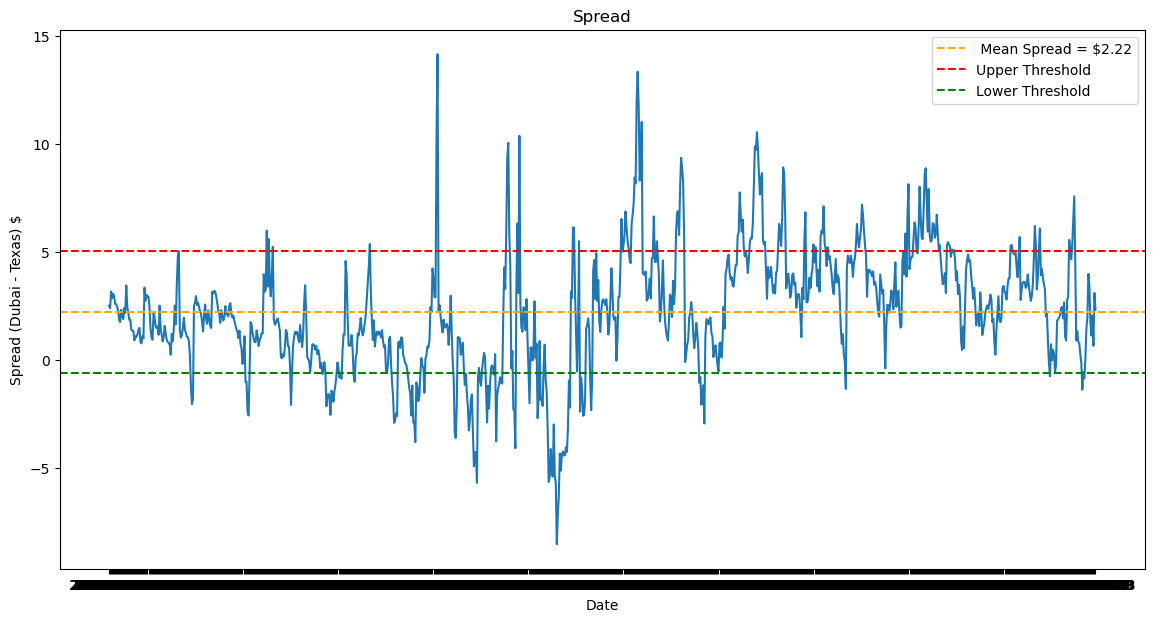

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(data_price['DATE'], data_price['Spread'])
plt.axhline(y=spread_mean, color='orange', linestyle='--', label=f' Mean Spread = ${round(spread_mean,2)}')
plt.axhline(y=upper_threshold_spread, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(y=lower_threshold_spread, color='green', linestyle='--', label='Lower Threshold')
plt.title('Spread')
plt.xlabel('Date')
plt.ylabel('Spread (Dubai - Texas) $')
plt.legend()

In [7]:
data_price

,DATE,Dubai,Texas,UK,Dubai Price,WTI,Brent,Spread,Spread_Signal
0,2020-07-07,36.1,28.4,12.5,43.09,40.59,43.28,2.50,0
1,2020-07-08,35.9,29.0,19.0,43.29,40.91,43.67,2.38,0
2,2020-07-09,34.9,27.2,14.8,42.79,39.64,42.35,3.15,0
3,2020-07-10,33.4,22.9,11.2,43.40,40.56,43.27,2.84,0
4,2020-07-13,39.8,29.9,16.8,43.10,40.06,42.85,3.04,0
...,...,...,...,...,...,...,...,...,...
972,2024-08-27,35.9,25.7,17.1,77.61,76.50,81.51,1.11,0
973,2024-08-28,36.9,27.1,16.2,77.53,75.49,80.04,2.04,0
974,2024-08-29,36.8,25.7,14.0,77.54,76.90,81.55,0.64,0
975,2024-08-30,35.6,25.6,13.5,77.60,74.52,80.20,3.08,0


## What would be the P&L?

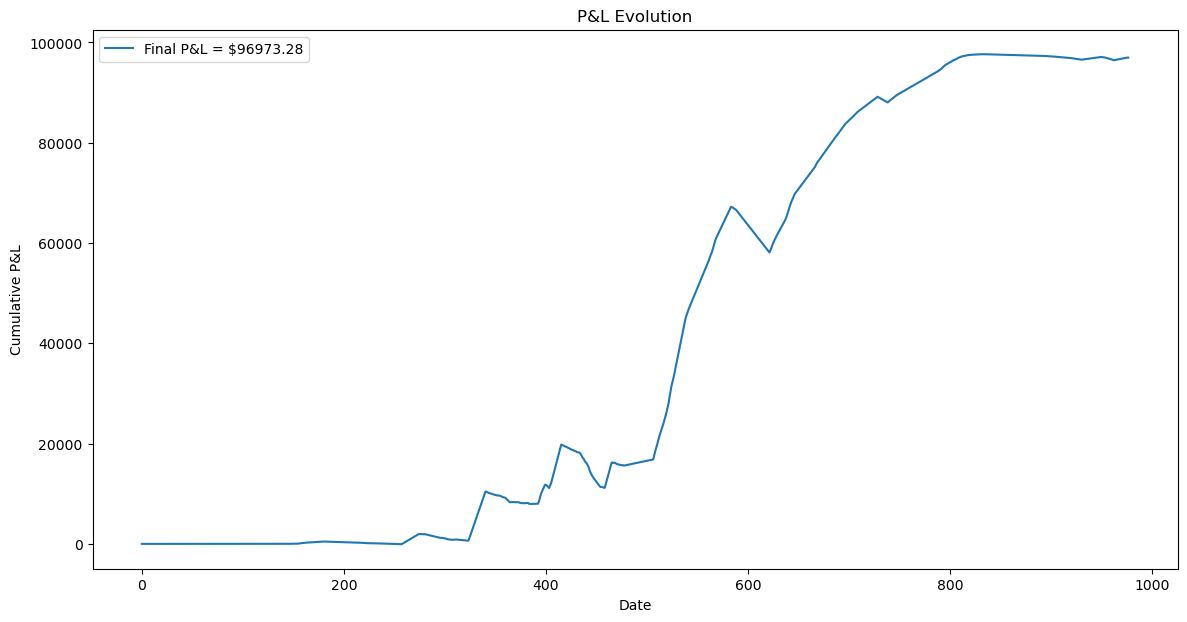

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assume 'spread_mean' is already defined, and 'Spread_Signal' is a column in your DataFrame

data_price["Daily P&L"] = 0.0
net_position = 0  # +1 for long Dubai / short Texas, -1 for short Dubai / long Texas
# Interpolate the missing values in the 'Spread' column (linear interpolation by default)

average_spread = []  # Move the list outside of the loop

for i in range(0, len(data_price) - 1):
    current_spread = data_price.iloc[i]["Spread"]
    next_spread = data_price.iloc[i+1]["Spread"]
    signal = data_price.iloc[i]['Spread_Signal']

    if abs(current_spread - spread_mean) < 0.01 and net_position >= 1:
        data_price.iloc[i, data_price.columns.get_loc("Daily P&L")] = (current_spread - np.array(average_spread).mean()) * net_position
        net_position = 0  # Clear positions at the mean
        average_spread.clear()

    if abs(current_spread - spread_mean) < 0.01 and net_position <= -1:
        data_price.iloc[i, data_price.columns.get_loc("Daily P&L")] = (np.array(average_spread).mean() - current_spread) * abs(net_position)
        net_position = 0  # Clear positions at the mean
        average_spread.clear()

    if signal == 1:
        net_position += 1
        average_spread.append(current_spread)

    if signal == -1:
        net_position -= 1
        average_spread.append(current_spread)

    if net_position >= 1:
        data_price.iloc[i+1, data_price.columns.get_loc("Daily P&L")] = (next_spread - np.array(average_spread).mean()) * net_position

    if net_position <= -1:
        data_price.iloc[i+1, data_price.columns.get_loc("Daily P&L")] = (np.array(average_spread).mean() - next_spread) * abs(net_position)

    if signal == 0 and i > 0:
        data_price.iloc[i, data_price.columns.get_loc("Daily P&L")] = data_price.iloc[i-1]["Daily P&L"]

# Calculate cumulative P&L
data_price["Cumulative P&L"] = data_price["Daily P&L"].cumsum()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data_price.index, data_price["Cumulative P&L"], label=f"Final P&L = ${data_price['Cumulative P&L'].iloc[-1]:.2f}")
plt.title("P&L Evolution")
plt.ylabel("Cumulative P&L")
plt.xlabel("Date")
plt.legend()


## This is arbitrage and the losses are due to say immediate move say you long one contract and then the next spread goes to the mean